In [1]:
from utils import *
import math
import matplotlib.pyplot as plt

from load_data import corpus_train, corpus_dev, corpus_test
from pcfg import grammar, lexicon, list_all_symbols, nb_tags, nb_all_symbols
from oov import tagger

building pcfg from corpus train

building oov tagger

8958  words in lexicon
7427  words in lexicon having an embedding
(7427, 64)

##################################



In [2]:
if True: #test oov print("test of the oov tagger")
    print("")

    sentences_test = [sentence(postag) for postag in corpus_test]
    print(sentences_test[0])
    print("")

    for word in sentences_test[0].split():
        print(word, tagger(word,viz_oov = True))
        print("")
    print("")

    print("##################################")
    print("")


- Février 2005 : le parquet de Paris requiert un non- lieu en_faveur_de Jean Tiberi , accordé par le juge Armand Riberolles .

- {'AP': 4.0167700851306945e-05, 'SENT': 0.00039621660995731037, 'CC': 0.01080511152900157, 'AdP': 9.079925654623167e-05, 'ADV': 0.01080511152900157, 'PONCT': 0.977862593374642}

Février  is an OOV
Janvier  is the closest word (meaning) found among lexicon words having an embedding
Février {'NP': 0.16144503240832844, 'AP': 0.0002857719141259512, 'SENT': 0.0003859434602566968, 'NC': 0.8378832522172889}

2005 {'NP': 0.16144503240832844, 'AP': 0.0002857719141259512, 'SENT': 0.0003859434602566968, 'NC': 0.8378832522172889}

: {'SENT': 0.0004050222762251924, 'PONCT': 0.9995949777237748}

le {'NP': 6.962458729169102e-05, 'DET': 0.9589394407684606, 'CLO': 0.04099093464424767}

parquet {'NP': 0.16144503240832844, 'AP': 0.0002857719141259512, 'SENT': 0.0003859434602566968, 'NC': 0.8378832522172889}

de {'NP': 1.5346649745961684e-06, 'DET': 0.02113694069511303, 'P': 0.9

In [7]:
if False: #test cyk
    binary_grammar = {"SENT":{("GRP1","GRP2"):1},"GRP1":{("ADV","VERB"):1},"GRP2":{("ART","NOM"):1}}
    tagger = {"Il":{"ADV":1},"demande":{"VERB":1},"le":{"ART":1},"renvoi":{"NOM":1}}
    list_all_symbols = ["SENT","GRP1","GRP2","ADV","VERB","ART","NOM","PUNCT"]  #redefining variable
    nb_tags = 8 
    nb_all_symbols = len(list_all_symbols) #redefining variable
    symbol_to_id = {tag:i for (i,tag) in enumerate(list_all_symbols)}


else:
    for (root,rules) in grammar.items():
        for (right, proba) in rules.items():
            #print(root, right, proba)
            if len(right)!=2:
                print("Found a rule right hand with a number of symbols different from 2")
        if np.abs(np.sum(list(rules.values()))-1)>10**-10:
            print(np.sum(list(rules.values())))
            print("Found a law for derivations of root tag which does not sum to 1")
    
    for (word, tags) in lexicon.items():
        if np.abs(np.sum(list(tags.values()))-1)>10**-10:
            print(np.sum(list(tags.values())))
            print("Found a law for word tag which does not sum to 1")
            
    
    print(list_all_symbols[:nb_tags])
    print(list_all_symbols[nb_tags:])
    #if the id of a symbol is above nb_tags, its an artificial symbol added for normalization (not a gramm tag)
    symbol_to_id = {symbol:i for (i,symbol) in enumerate(list_all_symbols)}

['ADJ', 'ADJWH', 'ADV', 'ADVWH', 'AP', 'AdP', 'CC', 'CLO', 'CLR', 'CLS', 'COORD', 'CS', 'DET', 'DETWH', 'ET', 'I', 'NC', 'NP', 'NPP', 'P', 'P+D', 'P+PRO', 'PONCT', 'PP', 'PREF', 'PRO', 'PROREL', 'SENT', 'Sint', 'Srel', 'Ssub', 'V', 'VIMP', 'VINF', 'VN', 'VPP', 'VPR', 'VPinf', 'VPpart', 'VS']
['NEW_0', 'NEW_1', 'NEW_10', 'NEW_100', 'NEW_1000', 'NEW_1001', 'NEW_1002', 'NEW_1003', 'NEW_1004', 'NEW_1005', 'NEW_1006', 'NEW_1007', 'NEW_1008', 'NEW_1009', 'NEW_101', 'NEW_1010', 'NEW_1011', 'NEW_1012', 'NEW_1013', 'NEW_1014', 'NEW_1015', 'NEW_1016', 'NEW_1017', 'NEW_1018', 'NEW_1019', 'NEW_102', 'NEW_1020', 'NEW_1021', 'NEW_1022', 'NEW_1023', 'NEW_1024', 'NEW_1025', 'NEW_1026', 'NEW_1027', 'NEW_1028', 'NEW_1029', 'NEW_103', 'NEW_1030', 'NEW_1031', 'NEW_1032', 'NEW_1033', 'NEW_1034', 'NEW_1035', 'NEW_1036', 'NEW_1037', 'NEW_1038', 'NEW_1039', 'NEW_104', 'NEW_1040', 'NEW_1041', 'NEW_1042', 'NEW_1043', 'NEW_1044', 'NEW_1045', 'NEW_1046', 'NEW_1047', 'NEW_1048', 'NEW_1049', 'NEW_105', 'NEW_1050', 

In [8]:
EPS = math.pow(10,-10)

def compute_CYK_tables(sentence, viz_oov = False):
    #(cf. https://en.wikipedia.org/wiki/CYK_algorithm)
    #finding most likely symbol deriving each substring, for increasing length of substring (from 1 to length of the sentence)
    #and storing each time the position of the cut and the grammar rule enabling to reach such most likely derivation
    
    nb_words = len(sentence)
   
    max_proba_derivation = np.zeros((nb_words,nb_words,nb_all_symbols))
    #max_proba_derivation[s,l,a] is the maximum probability of
    #a parsing where symbol a derives substring x_s...x_(s+l)
    
    split_reaching_max = np.zeros((nb_words,nb_words,nb_all_symbols,3))
    #split_reaching_max[s,l,a,0] stores index cut
    #split_reaching_max[s,l,a,1] stores symbol b
    #split_reaching_max[s,l,a,2] stores symbol c
    
    #(i) b derives x_s...x_(s+cut), c derives x_(s+cut)...x_(s+l)
    #and a rewrites bc (a->bc in the grammar)
    
    #(ii) the splitting <cut,b,c> defined by (i) is the one enabling
    #to reach the maximum probability for a to derives  x_s...x_(s+l)
    #(ie enabling to reach max_proba_derivation[s,l,a])

    #probabilities of tags for unary strings (words)
    for (position_word,word) in enumerate(sentence):
        tags = tagger(word, viz_oov = viz_oov) #tagger[word] #
        for (tag, proba) in tags.items():
            id_tag = symbol_to_id[tag]
            max_proba_derivation[position_word,0,id_tag] = proba
            
    #print(max_proba_derivation[:,0,:])
    
    for l in range(1, nb_words):
        #we will consider symbols deriving strings of length l+1...
        
        for s in range(nb_words-l):
            #... and starting at index s of the sentence
            
            for cut in range(0,l): 
                #... and such that the symbol can rewrite as two symbols AB
                #with A deriving substring until index cut included, and B deriving substring from index cut+1
                
                for (root_tag, rules) in grammar.items():
                    #root_tag is the left hand symbol of the grammar rule
                    #rules are the PCFC rules for derivation of root_tag
                    
                    idx_root_tag = symbol_to_id[root_tag]
                    
                    for (split, proba) in rules.items():
                        #root_tag can rewrite split[0]split[1] with probability proba
                        
                        if len(split)==2: #disregard rules A->B, consider only A->BC
                            
                            idx_left_tag = symbol_to_id[split[0]] #idx of left split tag
                            idx_right_tag = symbol_to_id[split[1]] #idx of right split tag
                                                        
                            proba_decomposition = proba
                            proba_decomposition *= max_proba_derivation[s,cut,idx_left_tag]
                            proba_decomposition *= max_proba_derivation[s+cut+1,l-cut-1,idx_right_tag]
                            
                            if proba_decomposition > max_proba_derivation[s,l,idx_root_tag]:
                                #therefore, we found a new decomposition <cut,split[0],split[1]>
                                #reaching a highest probability for root_tag to derive substring x_s...x_(s+l)

                                max_proba_derivation[s,l,idx_root_tag] = proba_decomposition
                                split_reaching_max[s,l,idx_root_tag,0] = cut
                                split_reaching_max[s,l,idx_root_tag,1] = idx_left_tag
                                split_reaching_max[s,l,idx_root_tag,2] = idx_right_tag
    
        #print(max_proba_derivation[:,l,:])
                            
    return max_proba_derivation, split_reaching_max.astype(int)

#Rq for report : max_proba_derivation is non zero if there exists a triplet such that both are non zero and ...


def parse_substring(s,l,idx_root_tag, sentence, max_proba_derivation, split_reaching_max):
    #parse substring beginning at index s of sentence, of length l+1, and tagged as idx_root_tag
    
    nb_words = max_proba_derivation.shape[0]
        
    if l==0: #void string        
        return sentence[s]
    
    else: #split enabling to reach max_proba_derivation[s,l,idx_root_tag]
        cut = split_reaching_max[s,l,idx_root_tag,0]
        idx_left_tag = split_reaching_max[s,l,idx_root_tag,1]
        idx_right_tag = split_reaching_max[s,l,idx_root_tag,2]
        
        left_tag = list_all_symbols[idx_left_tag]
        right_tag = list_all_symbols[idx_right_tag]
        
        #print(l,cut,l-cut)
                    
        return [[left_tag,parse_substring(s, cut, idx_left_tag, sentence, max_proba_derivation, split_reaching_max)],
                [right_tag,parse_substring(s+cut+1, l-cut-1, idx_right_tag, sentence, max_proba_derivation, split_reaching_max)]]
        
def remove_artificial_symbols(parsing_dico):
    if type(parsing_dico)==str:
        return parsing_dico
    else:
        new_parsing_dico = []
        for el in parsing_dico:
            root_tag = el[0]
            rules = el[1]
            if symbol_to_id[root_tag]>=nb_tags: #artificial symbol
                dico = remove_artificial_symbols(rules)
                new_parsing_dico.append(dico)
            else:
                new_parsing_dico.append([root_tag, rules])
        return new_parsing_dico
            
def parse(sentence, viz_oov = False):

    sentence = sentence.split()

    nb_words = len(sentence)
    
    max_proba_derivation, split_reaching_max = compute_CYK_tables(sentence, viz_oov = viz_oov)    
        
    #idx_root_tag = np.argmax(max_proba_derivation[0,nb_words,:])
    idx_root_tag = symbol_to_id["SENT"]
    #rq ca devrait etre toujours S_0 à ce point !!!
    
    parsing_dico = parse_substring(0,nb_words-1,idx_root_tag, sentence, max_proba_derivation, split_reaching_max)
    
    print(parsing_dico)
    
    #res = remove_artificial_symbols(parsing_dico)
    res = parsing_dico
    
    return res

def reformat_parsing(parsing):
    #converting parsing stored as a dictionnary into the required format (with nested brackets)
    
    if type(parsing)==str:
        return parsing

    else:
        string=""
        for el in parsing:
            root_tag = el[0]
            parsing_substring = el[1]
            string = string + "(" + root_tag + " " + reformat_parsing(parsing_substring) + ")" + " "
        string = string[:-1]
        return string    

def parser(sentence, viz_oov = False):
    return "( (SENT " + reformat_parsing(parse(sentence, viz_oov = viz_oov)) + "))"    

In [14]:
postagged_sent = corpus_test[1]

print("Sentence")
#sent = sentence(postagged_sent)
sent = "Il demande le renvoi ."
print(sent)
print("")

#print("Ground truth : ")
#print(postagged_sent)
#print("")

print("My parsing : ")
parsing = parser(sent, viz_oov = True)
print(parsing)

Sentence
Il demande le renvoi .

My parsing : 
[['VN', [['CLS', 'Il'], ['V', 'demande']]], ['NEW_7144', [['NP', [['DET', 'le'], ['NC', 'renvoi']]], ['PONCT', '.']]]]
( (SENT (VN (CLS Il) (V demande)) (NEW_7144 (NP (DET le) (NC renvoi)) (PONCT .))))


['(', '(SENT', '(VN', '(CLS', 'Il)', '(V', 'demande))', '(NEW_7144', '(NP', '(DET', 'le)', '(NC', 'renvoi))', '(PONCT', '.))))']


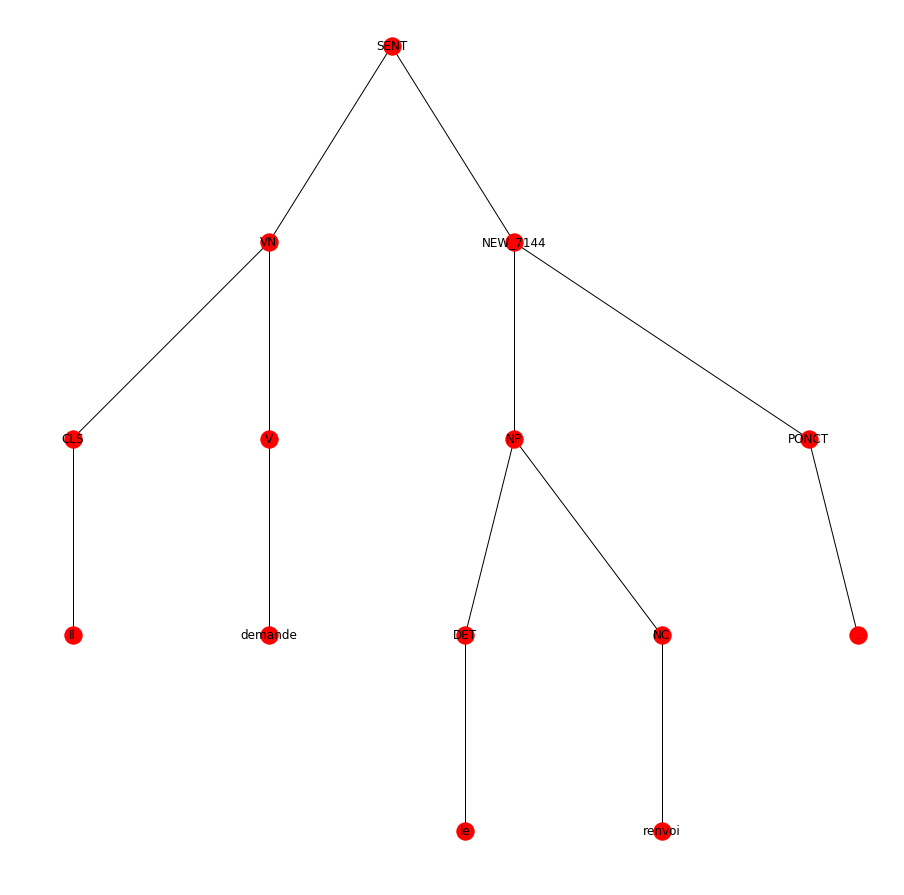

In [15]:
from utils_draw_tree import draw_tree
draw_tree(parsing)
plt.show()